# Lecture 4) Cross-Validation

In [24]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import sklearn as sl

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, roc_auc_score, classification_report, accuracy_score, confusion_matrix
from sklearn.metrics import mean_squared_error 
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA
from sklearn import neighbors
from sklearn.model_selection import cross_val_score
from sklearn import linear_model


%matplotlib inline
import scipy as sc
import math as ma
from scipy import linalg, optimize, constants, interpolate, special, stats
from math import exp, pow, sqrt, log

import seaborn as sns #spezielle Graphikdarstellungen
import statsmodels.api as sm
import statsmodels.stats.api as sms

Als Datensatz für dieses Tutorial verwenden wir den "Auto-Datensatz" (Quelle: StatLib library). Der Datensatz enthält eine ganze Menge Variablen.

- mpg
miles per gallon
- cylinders
Number of cylinders between 4 and 8
- displacement
Engine displacement (cu. inches)
- horsepower
Engine horsepower
- weight
Vehicle weight (lbs.)
- acceleration
Time to accelerate from 0 to 60 mph (sec.)
- year
Model year (modulo 100)
- origin
Origin of car (1. American, 2. European, 3. Japanese)
- name
Vehicle name

## Zielgröße ist mpg (miles per gallon)!

In [25]:
Auto = pd.read_csv("../../data-sets/Auto.csv")
Auto.head()

,mpg,cylinders,displacement,horsepower,weight,acceleration,year,origin,name
0,18.0,8,307.0,130,3504,12.0,70,1,chevrolet chevelle malibu
1,15.0,8,350.0,165,3693,11.5,70,1,buick skylark 320
2,18.0,8,318.0,150,3436,11.0,70,1,plymouth satellite
3,16.0,8,304.0,150,3433,12.0,70,1,amc rebel sst
4,17.0,8,302.0,140,3449,10.5,70,1,ford torino


In [26]:
Auto.dtypes

mpg             float64
cylinders         int64
displacement    float64
horsepower        int64
weight            int64
acceleration    float64
year              int64
origin            int64
name             object
dtype: object

Zunächst ein kurzer Überblick über den (reduzierten) Datensatz: 

In [27]:
Auto1=Auto[['mpg','cylinders','displacement','horsepower','weight','acceleration','year']]
Auto1.head()

,mpg,cylinders,displacement,horsepower,weight,acceleration,year
0,18.0,8,307.0,130,3504,12.0,70
1,15.0,8,350.0,165,3693,11.5,70
2,18.0,8,318.0,150,3436,11.0,70
3,16.0,8,304.0,150,3433,12.0,70
4,17.0,8,302.0,140,3449,10.5,70


Ein Pairplot zeigt erstmal die Abhängigkeitsstrukturen der Variablen im Überblick:

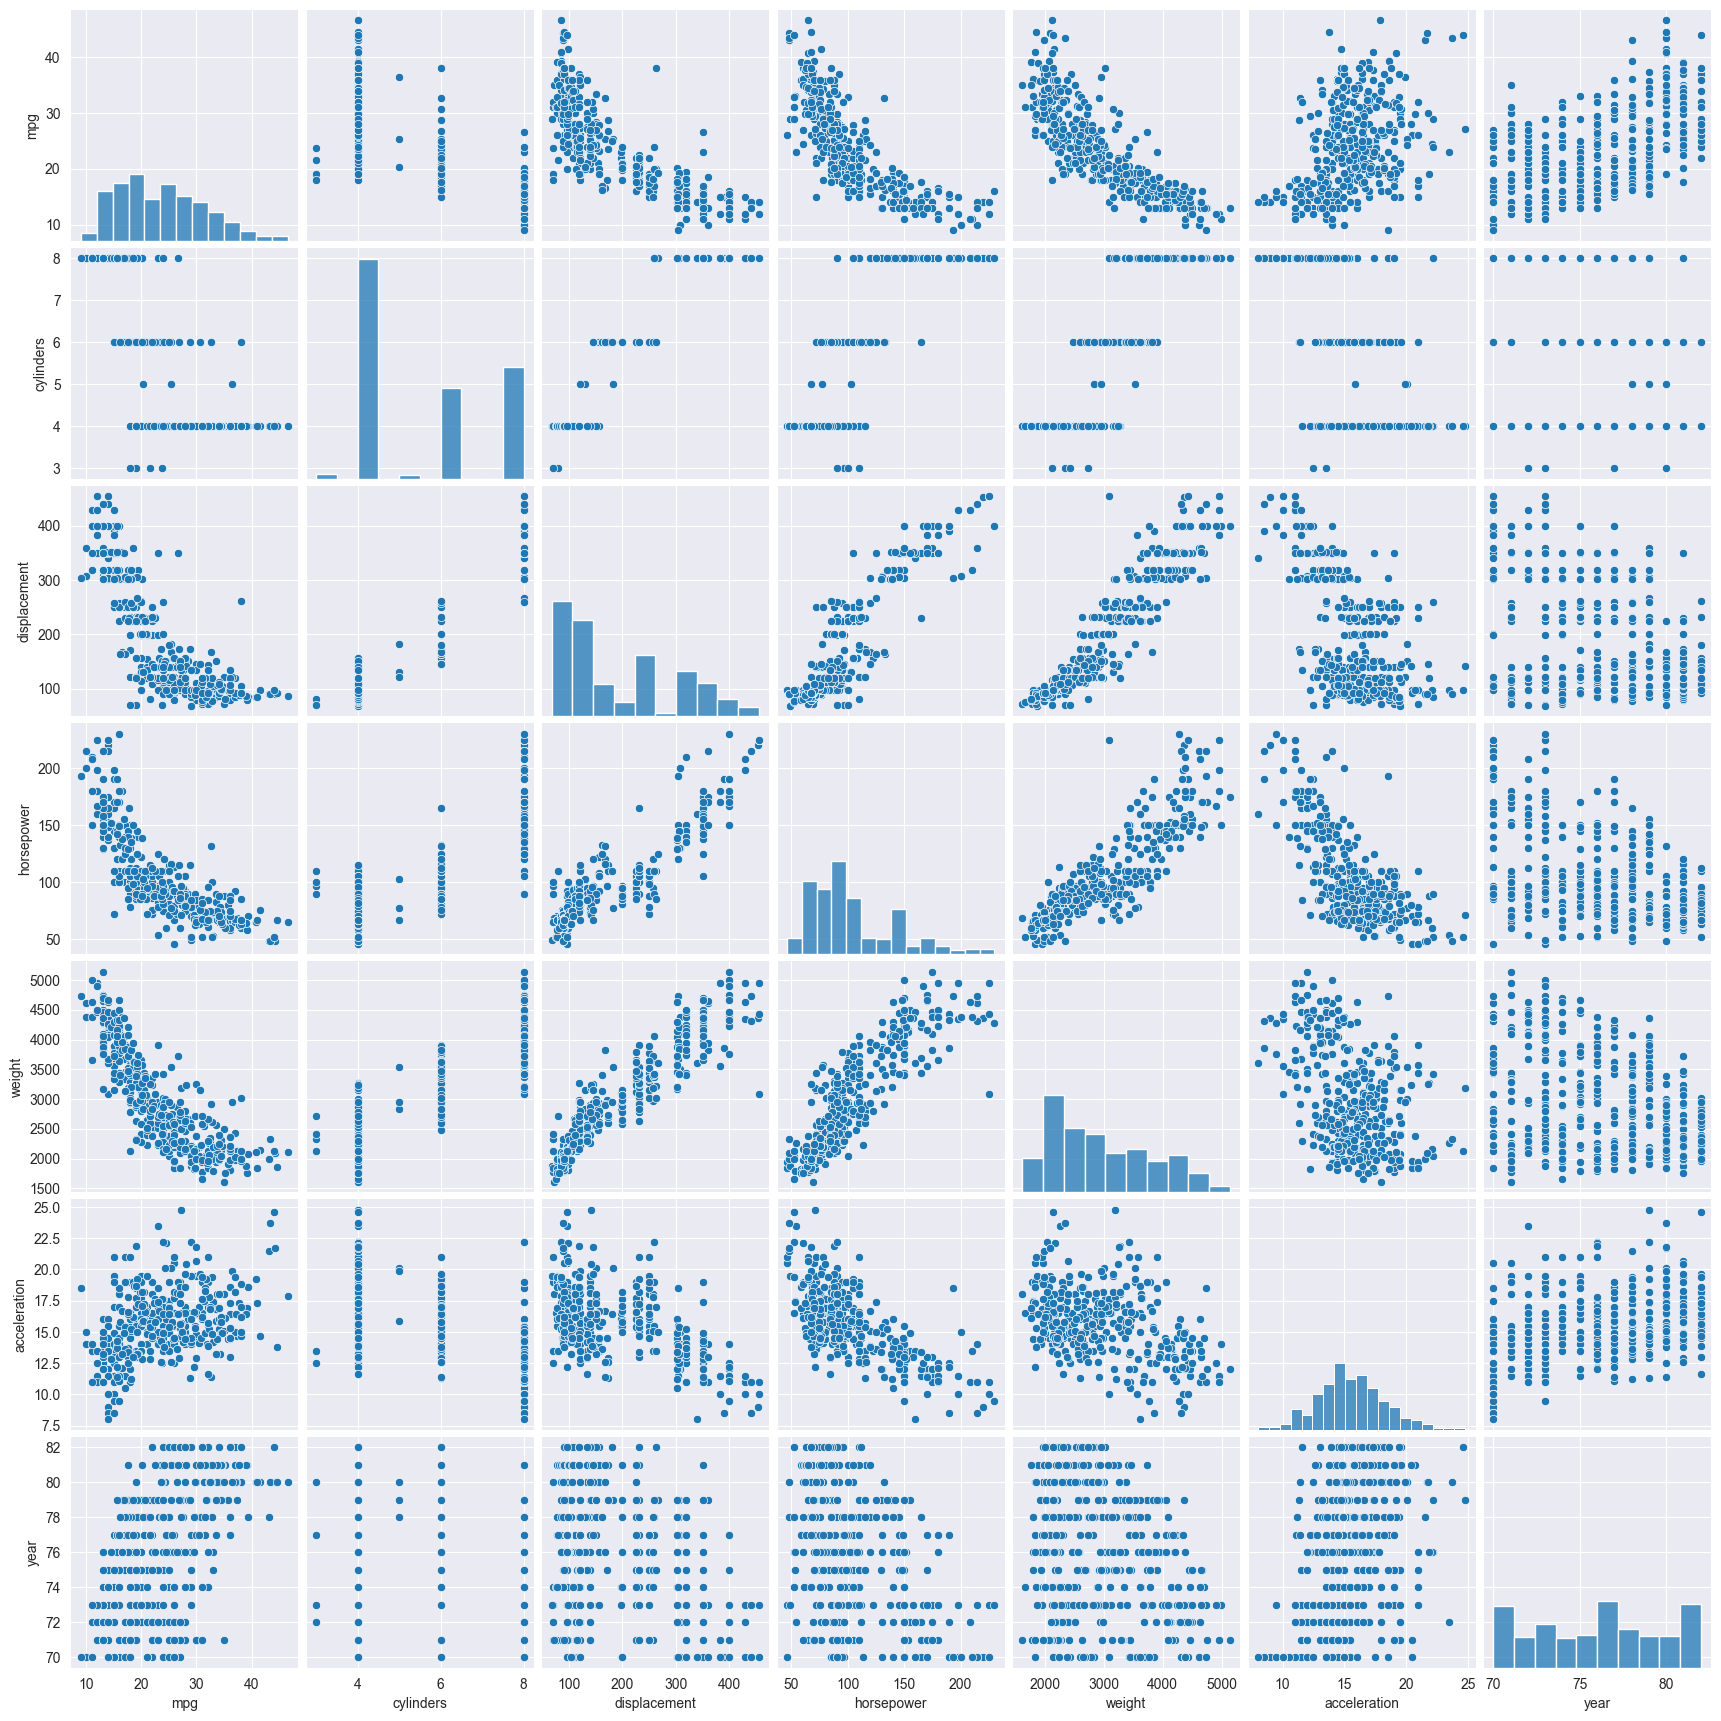

In [28]:
sns.pairplot(Auto1);

Quantifizieren können wir unser "Gefühl" bezüglich der Daten mit Hilfe der Korrelationsmatrix:

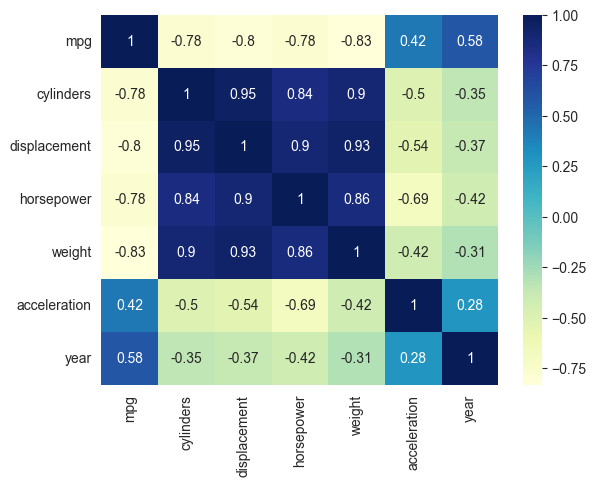

In [29]:
# Zeichne die Korrelations-Heatmap

sns.heatmap(Auto1.corr(), cmap="YlGnBu", annot=True, )
plt.show()

<Axes: >

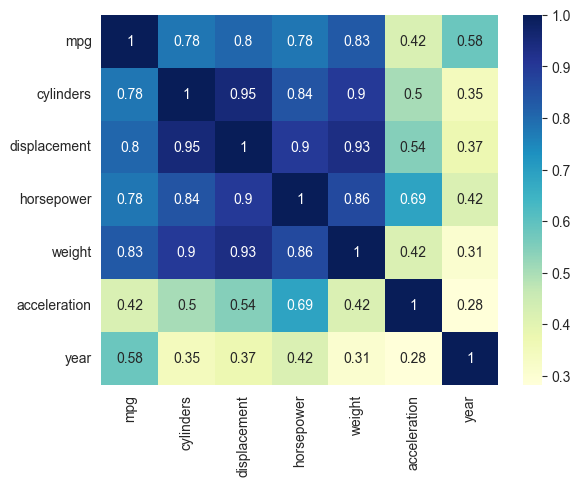

In [30]:
sns.heatmap(Auto1.corr().abs(), cmap="YlGnBu", annot=True)

Das Gewicht "weight", die "horsepower" sowie die Anzahl der "cylinders" haben den größten (linearen) Einfluß auf die Zielgröße. Man sieht aber auch, daß die Variablen untereinander zum Teil stark korrelieren.

Einen ersten Versuch machen wir jetzt mit einem Modell, das nur die "horsepower" berücksichtigt. Als Modell wählen wir ein Polynom:

$Y=\beta_0+\beta_1 X + \beta_2 X^2+...+ \beta_p X^p + \epsilon$

Die Frage lautet jetzt: wie muß man den optimalen Grad des Polynoms wählen?

## 4.1) Analyse des Einflusses der Auswahl von verschiedenen Testmengen

Macht es einen Unterschied, wenn wir bei der Entscheidung welcher Polynomgrad optimal ist verschiedene zufällige Train-Test-Splits haben?

In [31]:
Input = Auto1['horsepower']
Target = Auto1['mpg']

Wir legen zunächst eine Datenmatrix mit polynomialen Features bis zum Grad 10 an:

In [32]:
#Grad des Polnomes festlegen

polynomial_features= PolynomialFeatures(degree=10)

#Array aus den Daten machen
InputAr=np.array(Input).reshape(-1,1)


#polynomiale Features erzeugen
xp = polynomial_features.fit_transform(InputAr)

xp.shape

(397, 11)

jetzt splitten wir die Daten in 70% Training und 30% Testmenge 

In [33]:
X_train, X_test, y_train, y_test = train_test_split(xp, Target, test_size=0.3, shuffle=True)

Auf Basis dieser Trainings- und Testdaten können wir z.B. mit dem RMSE entscheiden, welcher Polynomgrad am besten paßt.
Dazu macht man am besten eine kleine Schleife, in der der Grad des Polynoms (Auswahl der Spalten der Feature-Matrix) schrittweise erhöht wird.

In [34]:
def RMSE_auto():
    grad_list=[] #Grad des Polynoms
    Err_tr_list=[]
    Err_test_list=[]
    size_list=[]

    X_train, X_test, y_train, y_test = train_test_split(xp, Target, test_size=0.3, shuffle=True)

    for k in range(1, 11):
        X_tr=X_train[:,0:k]
        X_te=X_test[:,0:k]

        dim=X_tr.shape[1]
        size_list.append(dim)
        #print(dim)

        olsmod = sm.OLS(y_train, X_tr) # Definition des Modelles
        olsres = olsmod.fit() # Parameterschätzung mit Hilfe der Daten - Modellname olsres und Anwenden der fit Funktion

        yTrPred = olsres.predict(X_tr)
        yTestPred = olsres.predict(X_te)

        Err_tr = sqrt(mean_squared_error(yTrPred,y_train))
        Err_test = sqrt(mean_squared_error(yTestPred,y_test))

        Err_tr_list.append(Err_tr)
        Err_test_list.append(Err_test)
        grad_list.append(k-1)
    return grad_list, Err_tr_list, Err_test_list, size_list

Eine graphische Darstellung der Trainings- und Testfehler hilft bei der Bewertung:

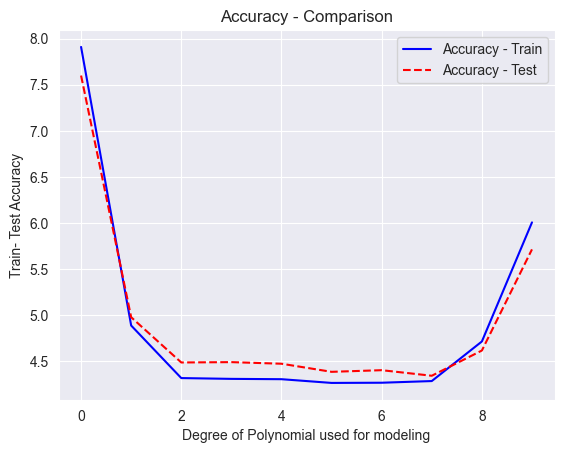

In [35]:
grad_list, Err_tr_list, Err_test_list, size_list = RMSE_auto()
plt.plot(grad_list,Err_tr_list,'b-',label='Accuracy - Train');
plt.plot(grad_list,Err_test_list,'r--',label='Accuracy - Test');

plt.xlabel('Degree of Polynomial used for modeling')
plt.ylabel('Train- Test Accuracy') 
plt.title('Accuracy - Comparison')

#Befehl zum Anzeigen der Graphik mit Angabe der Position
plt.legend(loc='upper right');

### Aufgabe 1)

Es ist völlig klar, daß die oben gezeigte Graphik (d.h. der RMSE) von der Wahl der Trainings- und Testmenge abhängt. Es wird ganz bestimmt Unterschiede im Verlauf geben. Die qualitative Aussage (Optimum bei Grad ?) sollte allerdings mehr oder weniger stabil sein.

- Lassen Sie die Rechnung von oben in einer Schleife 10 mal laufen und stellen sie die Kurven für die Trainings- sowie für die Testfehler jeweils zusammen in einer Graphik dar.  

$\underline{Hinweis}$: es bietet sich an eine Schleife laufen zu lassen, bei der am Ende zwei Listen mit den je 10 arrays für die Fehler rauspurzeln.

- Berechnen Sie eine mittlere Kurve für den Trainings- und Testfehler und zeichnen Sie diese Kurven.
- Welche Rückschlüsse kann man für den optimalen Grad des verwendeten Polynoms ziehen?

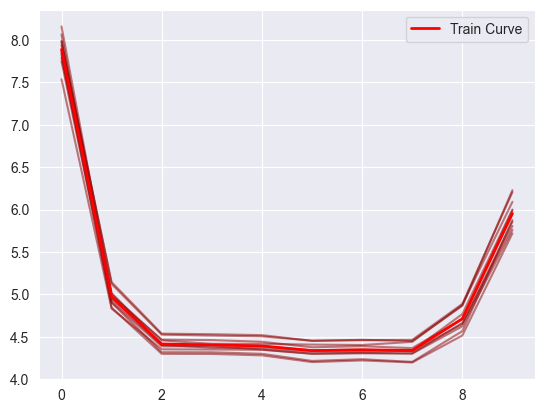

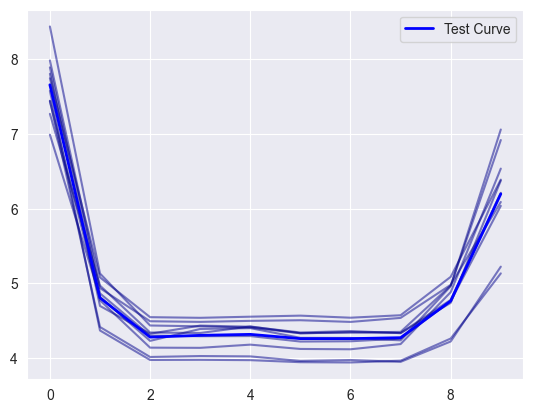

In [36]:
train_curves = []
test_curves = []
x = []
reps = 10
for i in range(reps):
    x.append(i)
    grad_list, Err_tr_list, Err_test_list, size_list = RMSE_auto()
    train_curves.append(Err_tr_list)
    test_curves.append(Err_test_list)

test_mean = np.array(test_curves).mean(axis=0)
train_mean = np.array(train_curves).mean(axis=0)

for y in train_curves:
    plt.plot(x, y, color='darkred', alpha=0.5)  # Grey lines for individual curves

plt.plot(x, train_mean, color='red', linewidth=2, label='Train Curve')  # Distinct style for the mean
plt.legend()
plt.show()



for y in test_curves:
    plt.plot(x, y, color='darkblue', alpha=0.5)  # Grey lines for individual curves

plt.plot(x, test_mean, color='blue', linewidth=2, label='Test Curve')  # Distinct style for the mean

plt.legend()
plt.show()

## 4.2) Crossvalidation - Leave-One-Out (LOOCV)

Wir haben in der Vorlesung überlegt, daß es sinnvoll wäre möglichst viele Daten zum Training verwenden zu können und trotzdem den Testfehler im Blick zu haben.
Als einfache Methode bei Datensätzen, die nicht zu groß sind bietet sich die Leave-One-Out Crossvalidation an.

Dabei verwenden wir jeden Datenpunkt für einen Modelllauf als 1-Punkt Testmenge, berechnen z.B. den RMSE und interpretieren den Mittelwert aller dieser berechneten Abweichungen dann als Erwartungswert für den Testfehler.

Interessant ist jetzt, ob wir mit diesem Verfahren ein ähnliches Ergebnis erzielen wie mit unserer ersten Strategie...

Wir starten mal mit der ersten Rechnung:

- wähle den ersten Punkt im Datensatz für den Test und den Rest der Punkte zum Trainieren.
- berechne dann die Modelle für Polynome bis zum Grad 10
- berechne den Fehler (RMSE) auf der Trainings- und der Testmenge (erster Punkt)

In [37]:
np.delete(xp, 0,0).shape

(396, 11)

In [38]:
np.delete(np.array(Target),0).shape

(396,)

### TestIndex=0 => erster Punkt zum Testen

In [39]:
TestIndex=0
X_train_LOO = np.delete(xp, TestIndex, 0)
X_test_LOO =xp[TestIndex]
y_train_LOO = np.delete(np.array(Target), TestIndex, 0)
y_test_LOO = np.array(Target)[TestIndex]

grad_list_LOO=[] #Grad des Polynoms
Err_tr_list_LOO=[]
Err_test_list_LOO=[]
size_list_LOO=[]

for k in range(1, 11):
    X_tr_LOO=X_train_LOO[:,0:k]
    X_te_LOO=X_test_LOO[0:k]
    
    dim_LOO=X_tr_LOO.shape[1]
    size_list_LOO.append(dim_LOO)
    #print(dim)
    
    olsmod_LOO = sm.OLS(y_train_LOO, X_tr_LOO) # Definition des Modelles
    olsres_LOO = olsmod_LOO.fit() # Parameterschätzung mit Hilfe der Daten - Modellname olsres und Anwenden der fit Funktion
    
    yTrPred_LOO = olsres_LOO.predict(X_tr_LOO)
    yTestPred_LOO = olsres_LOO.predict(X_te_LOO)
    
    Err_tr_LOO = sqrt(mean_squared_error(yTrPred_LOO,y_train_LOO)) 
    Err_test_LOO = sqrt((yTestPred_LOO-y_test_LOO)**2) 
    
    Err_tr_list_LOO.append(Err_tr_LOO)
    Err_test_list_LOO.append(Err_test_LOO)
    grad_list_LOO.append(k-1)

C:\Users\filip\AppData\Local\Temp\ipykernel_43724\414207533.py:27: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  Err_test_LOO = sqrt((yTestPred_LOO-y_test_LOO)**2)
C:\Users\filip\AppData\Local\Temp\ipykernel_43724\414207533.py:27: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  Err_test_LOO = sqrt((yTestPred_LOO-y_test_LOO)**2)
C:\Users\filip\AppData\Local\Temp\ipykernel_43724\414207533.py:27: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  Err_test_LOO = sqrt((yTestPr

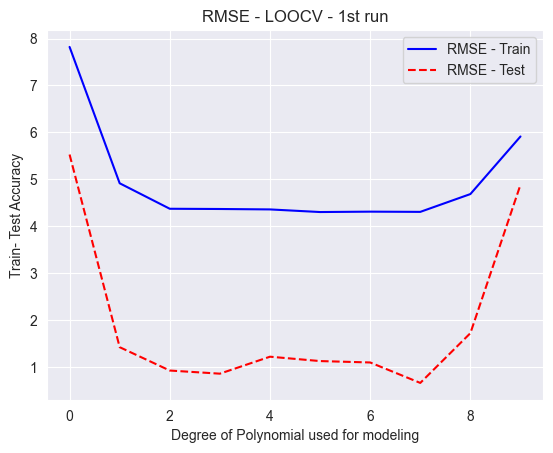

In [40]:
plt.plot(grad_list_LOO,Err_tr_list_LOO,'b-',label='RMSE - Train');
plt.plot(grad_list_LOO,Err_test_list_LOO,'r--',label='RMSE - Test');

plt.xlabel('Degree of Polynomial used for modeling')
plt.ylabel('Train- Test Accuracy') 
plt.title('RMSE - LOOCV - 1st run')

#Befehl zum Anzeigen der Graphik mit Angabe der Position
plt.legend(loc='upper right');

### Aufgabe 2)

- Iterieren sie in einer Schleife den Test-Index und berechnen Sie jeweils den Trainings- und den Testfehler
- Zeichnen Sie zwei Boxplots für die 397 berechneten RMSE-Werte für Training und Testfehler
- Zeichnen Sie eine Graphik mit dem Erwartungswert des RMSE für die LOOCV

## 4.3) k-fold Crossvalidation

Die LOOCV ist ein sehr gutes Mittel um bei (nicht zu großen) Datensätzen einen Schätzer für den Modellfehler zu generieren.
Allerdings ist das Ganze natürlich sehr rechenaufwendig und für große Datensätze oder komplexe Modelle kann es ziemlich lange dauern.

Die k-fold Crossvalidation ist ein gutes Mittel um den Rechenaufwand zu minimieren und trotzdem noch eine solide Abschätzung des Modellfehlers zu bekommen, die nicht zu sehr von der Wahl von Trainings- und Testmenge bestimmt wird.  

Man könnte die k-fold Crossvalidation analog zum Beispiel oben selbst realisieren. Scikit Learn ermöglicht das allerdings deutlich komfortabler.

Man muß dazu als Modell allerdings das lineare Modell von ScikitLearn nutzen:

from sklearn import linear_model
reg = linear_model.LinearRegression()

Dann läßt sich mit Hilfe des cross_val_score

from sklearn.model_selection import cross_val_score

ganz einfach eine k-fold Crossvalidation durchführen:


In [41]:
from sklearn import linear_model
from sklearn.model_selection import cross_val_score

In [42]:
print(xp.shape)
print(Target.shape)

(397, 11)
(397,)


In [43]:
# Spezifizieren des Modelles
reg = linear_model.LinearRegression()

### Durchführung der k-fold CV (Parameter k=cv=5)

- das verwendete Fehlermaß wird bei scoring festgelegt.

ACHTUNG:  
die gewählte Metrik muß für das Modell verfügbar sein. Eine Liste findet man unter:
https://scikit-learn.org/stable/modules/model_evaluation.html

Für unsere Regression hatten wir bisher den RMSE ausgewertet.
Sklearn hat dafür die Metrik "mean squared error". Aufgerufen wird sie als  

'neg_mean_squared_error'

### Besonderheit: 
der mittlere quadratische Fehler wird negativ ausgegeben. Man muß also den Absolutbetrag berechnen und die Wurzel ziehen um unseren RMSE zu erhalten.

Jetzt mal eine 5-fold CV:

In [44]:
scores = cross_val_score(reg, xp, Target, cv=5, scoring='neg_mean_squared_error')

RMSE_list_reg_5=np.sqrt(np.abs(scores)) #Betrag und Wurzel liefert RMSE
#print(RMSE_list_reg_5)

# Interessant: Mittelwert und Standardabweichung

print("Mittelwert und Standardabweichung des RMSE" , (RMSE_list_reg_5.mean(),RMSE_list_reg_5.std()))

Mittelwert und Standardabweichung des RMSE (np.float64(4.71681837228653), np.float64(1.3203400936929621))


### Aufgabe 3)

Das Implementieren der LOOCV war ok, aber vielleicht nicht das Schnellste.

- Überlegen Sie, wie man den cross_val_score benutzen könnte, um damit eine LOOCV zu realisieren
- Vergleichen Sie das Ergebnis (Mittelwerte des RMSE für Polynome bis Grad 10) mit dem selbst berechneten.
- Sollten die Ergebnisse gleich sein? Wenn ja/nein - warum?

### Aufgabe 4)

Im Beispiel oben hatten wir ein Polynom vom Grad 10 mit Hilfe einer 5-fold CV ausgewertet.

- Analysieren Sie mit Hilfe der 5-fold CV welches Polynom am besten geeignet ist (RMSE)
- Ändert sich das Ergebnis, wenn man andere Metriken benutzt, also z.B. den R2-score (Bestimmtheitsmaß) oder die erklärte Varianz.
- Fertigen Sie für die Analyse Graphiken des Testfehlers an.

### Einfluß der Anzahl der Folds

Frage: wie ändern sich Mittelwert und Standardabweichung des RMSE bei steigender Zahl der Folds?

Das können wir in einer Iteration untersuchen.
Am besten verwenden wir nur ein Polynom vom Grad 2 für den Fit. Das reicht ja eigentlich aus.


In [45]:
cv_list=[]
RMSE_mean_list=[]
RMSE_std_list=[]

for k in range(5, len(Target)):

    reg = linear_model.LinearRegression()
    scores = cross_val_score(reg, xp[:,0:3], Target, cv=k, scoring='neg_mean_squared_error')

    RMSE_list_reg=np.sqrt(np.abs(scores)) #Betrag und Wurzel liefert RMSE
    
    RMSE_mean=RMSE_list_reg.mean()
    RMSE_std=RMSE_list_reg.std()

    RMSE_mean_list.append(RMSE_mean)
    RMSE_std_list.append(RMSE_std)
    cv_list.append(k)

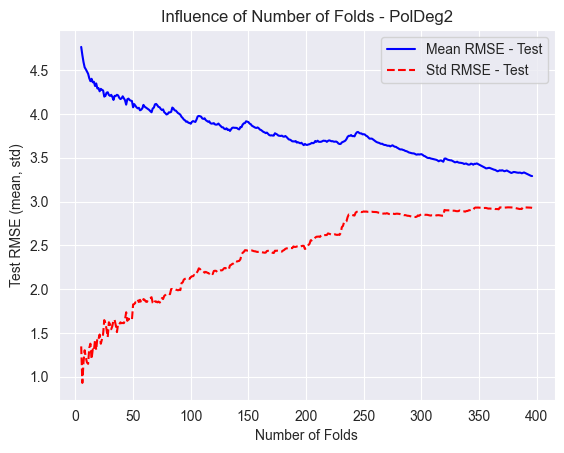

In [46]:
plt.plot(cv_list,RMSE_mean_list,'b-',label='Mean RMSE - Test');
plt.plot(cv_list,RMSE_std_list,'r--',label='Std RMSE - Test');

plt.xlabel('Number of Folds')
plt.ylabel('Test RMSE (mean, std)') 
plt.title('Influence of Number of Folds - PolDeg2')

#Befehl zum Anzeigen der Graphik mit Angabe der Position
plt.legend(loc='upper right');

#### Interpretation:  

- steigt die Anzahl der Folds, dann sind immer weniger Samples für einen Durchlauf in der Testmenge und es werden für eine CV jeweils mehr Einzelmengen analysiert.
- Am Anfang ist also die Varianz niedrig, aber die Schätzung für den RMSE liegt von Erwartungswert evtl. weiter weg
- werden mehr einzelne Testmengen für einen Durchlauf ausgewertet, dann steigt die Varianz, aber der Bias nimmt ab!